<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/Test_Shopee_minhat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/calibretaliation/DeepLearning20211

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32469, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 32469 (delta 0), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32469/32469), 1.68 GiB | 31.03 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Checking out files: 100% (32426/32426), done.


In [1]:
! pip install albumentations==0.4.6
! pip install sklearn

     |████████████████████████████████| 117 kB 34.5 MB/s 
     |████████████████████████████████| 948 kB 33.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=1a650ec20633cd4dfea7e82383375cf1703c20611a206f1633e1732ef0b12010
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [69]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
import albumentations.pytorch
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder


In [43]:
train_df = pd.read_csv('./DeepLearning20211/data/train.csv')
test_df = pd.read_csv('./DeepLearning20211/data/test.csv')
train_img_path = './DeepLearning20211/data/train_images'
test_img_path = './DeepLearning20211/data/test_images'

In [44]:
def my_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [45]:
train_df['file_path'] = train_df.image.apply(lambda x: os.path.join(train_img_path, x))
train_df.head(5)

,posting_id,image,image_phash,title,label_group,file_path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,./DeepLearning20211/data/train_images/0000a688...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,./DeepLearning20211/data/train_images/00039780...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,./DeepLearning20211/data/train_images/000a190f...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,./DeepLearning20211/data/train_images/00117e4f...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,./DeepLearning20211/data/train_images/00136d1c...


In [64]:
#Drop duplicate by p-hash
train_df = train_df.drop_duplicates(subset=['image_phash'],keep = 'first')
train_df = train_df.reset_index()
train_df.image_phash.value_counts()

bd32d361d0333939    1
bf89e03992680b7b    1
9a1a861da5e369e9    1
ae4bd13bd0cc95c4    1
fa9e81c38c23f598    1
                   ..
9eb14e97e0699661    1
f236a50d58a78dd8    1
a452da2f8d90276f    1
b0ee46e619b919c9    1
b2b011176f6c6e96    1
Name: image_phash, Length: 28735, dtype: int64

In [65]:
#check if label group preserved
train_df.label_group.value_counts()

1141798720    44
159351600     43
1091404026    39
3489985175    37
562358068     36
              ..
370710977      1
3601891778     1
2067677642     1
2213950251     1
1332066608     1
Name: label_group, Length: 11004, dtype: int64

In [67]:
group_k_fold = GroupKFold(n_splits= 5)
train_df['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(group_k_fold.split(train_df, None, train_df.label_group)):
    train_df.loc[valid_idx, 'fold'] = fold
train_df.head()

,index,posting_id,image,image_phash,title,label_group,file_path,fold
0,0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,./DeepLearning20211/data/train_images/0000a688...,2
1,1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,./DeepLearning20211/data/train_images/00039780...,3
2,2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,./DeepLearning20211/data/train_images/000a190f...,0
3,3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,./DeepLearning20211/data/train_images/00117e4f...,1
4,4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,./DeepLearning20211/data/train_images/00136d1c...,1


In [71]:
le = LabelEncoder()
train_df.label_group = le.fit_transform(train_df.label_group)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


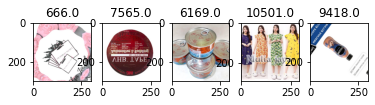

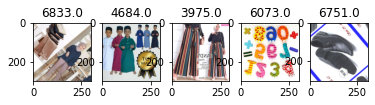

In [77]:
class ShopeeDataset(Dataset):

    def __init__(self, dataframe, dir_path, mode, transforms):
        self.dataframe = dataframe
        self.dir_path = dir_path
        self.augmentations = transforms
        self.mode = mode
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_info = self.dataframe.iloc[index]
        img = cv2.imread(img_info.file_path)
        label = torch.tensor([img_info['label_group']])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']   

        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(img_info.label_group).float()
      

transforms_train = albumentations.Compose([
    albumentations.augmentations.transforms.Resize(300, 300, interpolation = cv2.INTER_LANCZOS4), 
    albumentations.augmentations.transforms.Flip(),
    albumentations.augmentations.transforms.RandomBrightnessContrast(),
    albumentations.augmentations.transforms.RandomScale(),
    albumentations.augmentations.transforms.ShiftScaleRotate(rotate_limit=180, p=0.5, interpolation = cv2.INTER_LANCZOS4),
    albumentations.augmentations.transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2() 
    ])
transforms_valid = albumentations.Compose([
    albumentations.Resize(300, 300),
    albumentations.Normalize()
])
train_ds = ShopeeDataset(train_df, train_img_path, 'train' , transforms_train)

my_seed(33)

train_dl = DataLoader(train_ds, batch_size= 64, shuffle = False)
# visualize a batch
#num_samples = 10
#fig, ax = plt.subplots(1, num_samples, figsize=(25, 10))
#for i in range(num_samples):
#    ax[i].imshow((train_ds[24][0]).permute(1, 2, 0))
#    ax[i].axis('off')
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = i*5 + p
        img, label = train_ds[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())